In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

# Use Low Rank completion from pylop and pyproximal 
import pylops
import pyproximal 

KeyboardInterrupt: 

In [2]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_1000_40.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)

In [3]:
template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list']
label_list = dataset_list[0]['labels']

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Generate random walk for guessing structures
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

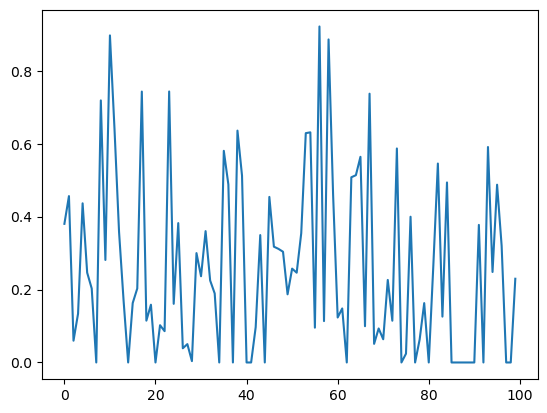

In [41]:
# Introducing missing data to the dataset at specific barcodes with some probabiliity between [0, 1]
missing_data_prob = np.random.normal(0.2, 0.3, num_monomers)
missing_data_prob[missing_data_prob < 0] = 0
missing_data_prob[missing_data_prob > 1] = 1
plt.plot(missing_data_prob)

In [16]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [17]:
# Get shuffle indices for shuffling dataset 
shuffle_indices = np.arange(num_observations)
np.random.shuffle(shuffle_indices)

observations_with_nan = np.array([squareform(pdist(x)) for x in X])
observations_with_nan = observations_with_nan[shuffle_indices, :, :]
polys_with_nan = np.array([x for x in X])
polys_with_nan = polys_with_nan[shuffle_indices, :, :]
existing_data = np.zeros(observations_with_nan.shape)
# Randomly add nan to the dataset based on the missing_data_prob
for i in range(num_observations):
    missing_indices = np.random.uniform(size=num_monomers) < missing_data_prob
    observations_with_nan[i, missing_indices, :] = 0
    observations_with_nan[i, :, missing_indices] = 0
    polys_with_nan[i, missing_indices, :] = np.nan
    existing_data[i, ~missing_indices, :] = 1
    existing_data[i, :, ~missing_indices] = 1
    
existing_data_flatten = np.array([x.flatten() for x in existing_data.astype(bool)])
observations_flatten = np.array([squareform(pdist(x)) for x in X])[shuffle_indices, :, :]
observations_flatten = np.array([x.flatten() for x in observations_flatten])
observations_flatten_with_nan = np.array([x.flatten() for x in observations_with_nan])
mean_impute_polys = interpolate_polymers(polys_with_nan)
mean_impute_maps = [squareform(pdist(x)) for x in mean_impute_polys]

In [7]:
def matrix_completion_k(k):
    bc1_nan_map = observations_flatten_with_nan[:, num_probes*k:num_probes*(k+1)]
    bc1_map = observations_flatten[:, num_probes*k:num_probes*(k+1)]
    
    # This is the indices of existing data
    existing_indices = np.where(existing_data_flatten[:, num_probes*k:num_probes*(k+1)].ravel())
    
    nx, ny = bc1_map.shape
    Rop = pylops.Restriction(ny*nx, 
                         existing_indices[0], dtype='float64')
    
    Ux, Sx, Vhx = np.linalg.svd(bc1_map, full_matrices=False)
    Uy, Sy, Vhy = np.linalg.svd(bc1_nan_map, full_matrices=False)
    
    mu1 = 1 * np.sum(Sx)
    y = Rop * bc1_map.ravel()
    f = pyproximal.L2(Rop, y)
    g = pyproximal.proximal.NuclearBall((ny, nx), mu1)

    Xpgc = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                        tau=1., niter=100, show=False)
    Xpgc = Xpgc.reshape(nx, ny)
    
    return Xpgc

In [36]:
def matrix_completion_k_Sy_1(k):
    bc1_nan_map = observations_flatten_with_nan[:, num_probes*k:num_probes*(k+1)]
    bc1_map = observations_flatten[:, num_probes*k:num_probes*(k+1)]
    
    # This is the indices of existing data
    existing_indices = np.where(existing_data_flatten[:, num_probes*k:num_probes*(k+1)].ravel())
    
    nx, ny = bc1_map.shape
    Rop = pylops.Restriction(ny*nx, 
                         existing_indices[0], dtype='float64')
    
    Ux, Sx, Vhx = np.linalg.svd(bc1_map, full_matrices=False)
    Uy, Sy, Vhy = np.linalg.svd(bc1_nan_map, full_matrices=False)
    
    mu1 = 0.5 * np.sum(Sy)
    y = Rop * bc1_map.ravel()
    f = pyproximal.L2(Rop, y)
    g = pyproximal.proximal.NuclearBall((ny, nx), mu1)

    Xpgc = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                        tau=1., niter=100, show=False)
    Xpgc = Xpgc.reshape(nx, ny)
    
    return Xpgc

In [9]:
def matrix_completion_surface_k(k):
    bc1_nan_map = observations_flatten_with_nan[:, num_probes*k:num_probes*(k+1)]
    bc1_map = observations_flatten[:, num_probes*k:num_probes*(k+1)]
    
    # This is the indices of existing data
    existing_indices = np.where(existing_data_flatten[:, num_probes*k:num_probes*(k+1)].ravel())
    
    nx, ny = bc1_map.shape
    Rop = pylops.Restriction(ny*nx, 
                         existing_indices[0], dtype='float64')
    
    Ux, Sx, Vhx = np.linalg.svd(bc1_map, full_matrices=False)
    Uy, Sy, Vhy = np.linalg.svd(bc1_nan_map, full_matrices=False)
    
    mu = 1
    y = Rop * bc1_map.ravel()
    f = pyproximal.L2(Rop, y)
    g = pyproximal.Nuclear((ny, nx), mu)

    Xpg = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                        tau=1., niter=100, show=False)
    Xpg = Xpg.reshape(nx, ny)

    # Recompute SVD and see how the singular values look like
    Upg, Spg, Vhpg = np.linalg.svd(Xpg, full_matrices=False)
    
    return Xpg

In [34]:
diff_list = []
for k in range(100):
    Ux, Sx, Vhx = np.linalg.svd(observations_flatten[:, num_probes*k:num_probes*(k+1)], full_matrices=False)
    Uy, Sy, Vhy = np.linalg.svd(observations_flatten_with_nan[:, num_probes*k:num_probes*(k+1)], full_matrices=False)
    diff_list.append(np.sum(Sx) - np.sum(Sy))

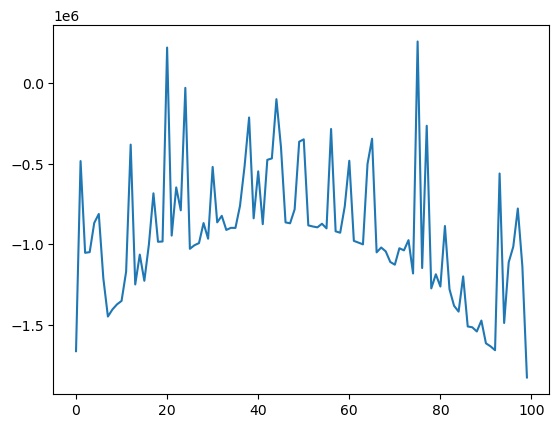

In [35]:
plt.plot(diff_list)

In [20]:
with multiprocessing.Pool() as pool:
    mc_pred_mp = pool.map(matrix_completion_k, range(num_probes))
    # mc_pred_mp_Sy = pool.map(matrix_completion_k_Sy_1, range(num_probes))

In [37]:
with multiprocessing.Pool() as pool:
    mc_pred_mp_Sy = pool.map(matrix_completion_k_Sy_1, range(num_probes))

In [21]:
mean_impute_flatten = [x.flatten() for x in mean_impute_maps]

In [22]:
np.linalg.norm(mean_impute_flatten - observations_flatten)

1069708.5582142693

In [23]:
np.linalg.norm(np.hstack(mc_pred_mp) - observations_flatten)

533829.830096767

In [38]:
np.linalg.norm(np.hstack(mc_pred_mp_Sy) - observations_flatten)

798461.4457334664

In [24]:
np.linalg.norm(np.hstack(mc_pred_mp) - observations_flatten) / np.linalg.norm(mean_impute_flatten - observations_flatten)

0.49904231016710027

In [39]:
np.linalg.norm(np.hstack(mc_pred_mp_Sy) - observations_flatten) / np.linalg.norm(mean_impute_flatten - observations_flatten)

0.7464289591796737

In [35]:
mc_pred_surface = [matrix_completion_surface_k(x) for x in tqdm(range(num_probes))]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
def mean_inputation(nan_2d_array):
    result = nan_2d_array.copy()
    for i in range(nan_2d_array.shape[0]):
        nan_indices = []
        for z, x in enumerate(nan_2d_array[i, :]):
            if x == 0 and z > 0:
                nan_indices.append(z)
            else:
                if not nan_indices:
                    prev_exist = x
                else:
                    diff = (x - prev_exist) / (len(nan_indices)+1)
                    for k, j in enumerate(nan_indices):
                        result[i, j] = prev_exist + diff*(k+1)
                    prev_exist = x
                    nan_indices = []
    return result

In [40]:
def mean_imputation_k(k):
    bc1_nan_map = observations_flatten_with_nan[:, num_probes*k:num_probes*(k+1)]
    return mean_inputation(bc1_nan_map)

In [41]:
mi_pred = [mean_imputation_k(x) for x in tqdm(range(num_probes))]

  0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
np.array(mc_pred).shape

(100, 10000, 100)

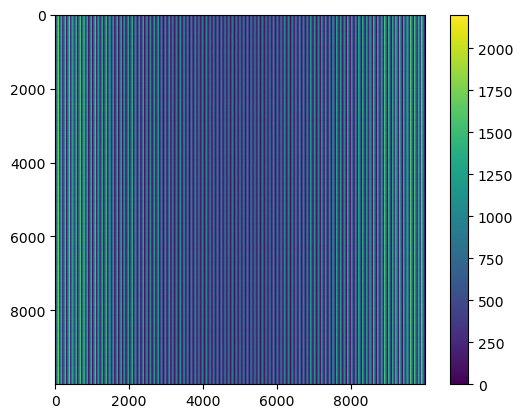

In [52]:
plt.imshow(observations_flatten)
plt.colorbar()

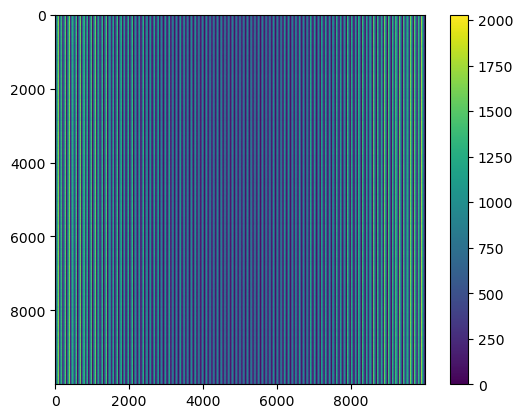

In [47]:
plt.imshow(np.hstack(mc_pred))
plt.colorbar()

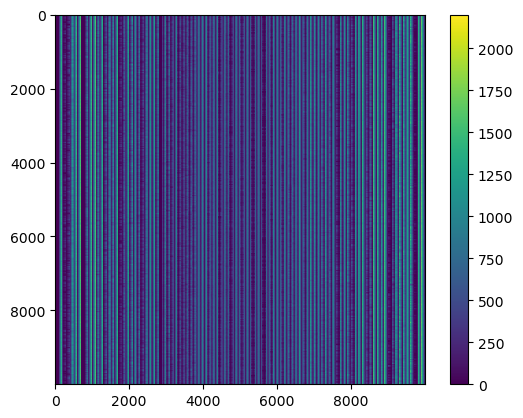

In [48]:
plt.imshow(np.hstack(mi_pred))
plt.colorbar()

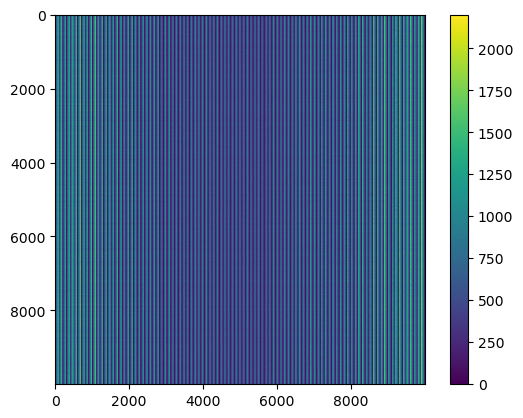

In [58]:
plt.imshow(np.hstack(mc_pred_surface))
plt.colorbar()

In [49]:
np.linalg.norm(np.hstack(mc_pred) - observations_flatten)

582689.709703036

In [50]:
np.linalg.norm(np.hstack(mi_pred) - observations_flatten)

4172751.0436129225

In [59]:
np.linalg.norm(np.hstack(mc_pred_surface) - observations_flatten)

2033592.663131635

In [67]:
mc_pred_surface_3d = [x.reshape(100, 100) for x in np.hstack(mc_pred_surface)]